In [1]:
!pip install torchbearer

    100% |████████████████████████████████| 92kB 3.6MB/s 
  Running setup.py bdist_wheel for torchbearer ... - \ done
  Stored in directory: /tmp/.cache/pip/wheels/6c/cb/69/466aef9cee879fb8f645bd602e34d45e754fb3dee2cb1a877a
Successfully built torchbearer
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import FashionMNIST

import torchbearer
import torchbearer.callbacks as callbacks
from torchbearer import Trial, state_key

MU = state_key('mu')
LOGVAR = state_key('logvar')

# Fashion MNIST Beta-VAE
## Model Definition
In this tutorial we will train a simple Beta-VAE on FashionMNIST with PyTorch and [torchbearer](https://github.com/ecs-vlc/torchbearer). Now that we have everything installed and imported, and our state keys defined, we can define our model. This is a simple, three layer CNN similar to the one used in the [Beta-VAE paper](https://openreview.net/forum?id=Sy2fzU9gl). 4 by 4 convolutions with a bit of padding help us to easily work out the output sizes for each layer.

In [3]:
class VAE(nn.Module):
    def __init__(self, latent_size):
        super(VAE, self).__init__()
        self.latent_size = latent_size

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 1, 2),   # B,  32, 28, 28
            nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1),  # B,  32, 14, 14
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1),  # B,  64,  7, 7
        )
        
        self.mu = nn.Linear(64 * 7 * 7, latent_size)
        self.logvar = nn.Linear(64 * 7 * 7, latent_size)
        
        self.upsample = nn.Linear(latent_size, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # B,  64,  14,  14
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 4, 2, 1, 1), # B,  32, 28, 28
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, 4, 1, 2)   # B, 1, 28, 28
        )

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x, state):
        image = x
        x = self.encoder(x).relu().view(x.size(0), -1)
        
        mu = self.mu(x)
        logvar = self.logvar(x)
        sample = self.reparameterize(mu, logvar)
        
        result = self.decoder(self.upsample(sample).relu().view(-1, 64, 7, 7))
        
        if state is not None:
            state[torchbearer.Y_TRUE] = image
            state[MU] = mu
            state[LOGVAR] = logvar
        
        return result

## Loading the Data
Ok, so now the model will encode the input to obtain a latent space, then sample from that space and decode to produce the output. It will also put anything that we need in state (in this case: the new target, the mean and the logvar). Next, we need some data, there's a small hack hidden here to make the torchvision dataset work with the csv files.

In [4]:
# Hack to make this work with the torchvision dataset

import codecs

def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)

def read_label_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2049
        length = get_int(data[4:8])
        parsed = np.frombuffer(data, dtype=np.uint8, offset=8)
        return torch.from_numpy(parsed).view(length).long()


def read_image_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2051
        length = get_int(data[4:8])
        num_rows = get_int(data[8:12])
        num_cols = get_int(data[12:16])
        parsed = np.frombuffer(data, dtype=np.uint8, offset=16)
        return torch.from_numpy(parsed).view(length, num_rows, num_cols)

root = '../input'
out = '../processed'
if not os.path.exists(out):
    os.mkdir(out)

training_set = (
    read_image_file(os.path.join(root, 'train-images-idx3-ubyte')),
    read_label_file(os.path.join(root, 'train-labels-idx1-ubyte'))
)
test_set = (
    read_image_file(os.path.join(root, 't10k-images-idx3-ubyte')),
    read_label_file(os.path.join(root, 't10k-labels-idx1-ubyte'))
)
with open(os.path.join(out, 'training.pt'), 'wb') as f:
    torch.save(training_set, f)
with open(os.path.join(out, 'test.pt'), 'wb') as f:
    torch.save(test_set, f)

In [5]:
transform = transforms.Compose([transforms.ToTensor()])  # No augmentation
trainset = FashionMNIST(root='../', train=True, transform=transform)
testset = FashionMNIST(root='../', train=False, transform=transform)
traingen = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=8)
testgen = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=8)

## KL Term
The final thing we need to train the model, is the KL divergence loss, with optional beta term. With torchbearer we can just use the add_to_loss decorator for this:

In [6]:
def beta_kl(mu_key, logvar_key, beta=5):
    @callbacks.add_to_loss
    def callback(state):
        mu = state[mu_key]
        logvar = state[logvar_key]
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) * beta
    return callback

## Visualisation
Since this is a VAE, it would be helpful to visualise some of the training progress, so we know how its doing. For that we can write a callback, here using Matplotlib (imported earlietr with inline mode enabled).

In [7]:
def plot_progress(key=torchbearer.Y_PRED, num_images=100, nrow=10):
    @callbacks.on_step_validation
    @callbacks.once_per_epoch
    def callback(state):
        images = state[key]
        image = make_grid(images[:num_images], nrow=nrow, normalize=True)[0, :, :]
        plt.imshow(image.detach().cpu().numpy(), cmap="gray")
        plt.show()
    
    return callback

## Training
Now that we have all of the things we need, we can create a trial instance and train the model:

0/20(t): loss=7124.6445, mse=0.0583, running_loss=6163.6567, running_mse=0.0451
1/20(t): loss=5928.6611, mse=0.0422, running_loss=5838.3042, running_mse=0.0408
2/20(t): loss=5768.4092, mse=0.04, running_loss=5767.6328, running_mse=0.0395
3/20(t): loss=5661.5806, mse=0.0386, running_loss=5636.4351, running_mse=0.0382
4/20(t): loss=5618.9092, mse=0.0379, running_loss=5623.8213, running_mse=0.038
5/20(t): loss=5569.3862, mse=0.0372, running_loss=5587.5264, running_mse=0.0371
6/20(t): loss=5540.166, mse=0.0367, running_loss=5539.5493, running_mse=0.0365
7/20(t): loss=5520.9194, mse=0.0364, running_loss=5484.8418, running_mse=0.0362
8/20(t): loss=5501.4526, mse=0.0361, running_loss=5503.8169, running_mse=0.036
9/20(t): loss=5479.6914, mse=0.0359, running_loss=5496.1553, running_mse=0.0361
10/20(t): loss=5477.5811, mse=0.0357, running_loss=5500.7095, running_mse=0.0359
11/20(t): loss=5464.7422, mse=0.0356, running_loss=5392.4922, running_mse=0.035
12/20(t): loss=5456.2085, mse=0.0355, runnin

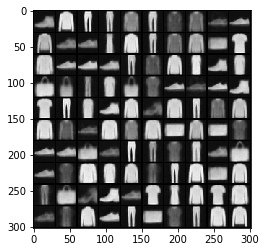

0/1(v): test_loss=4594.0176, test_mse=0.0264


{'test_mse': 0.0263975840061903, 'test_loss': 4594.017578125}

In [8]:
model = VAE(latent_size=10)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-4)
trial = Trial(model, optimizer, nn.MSELoss(reduction='sum'), metrics=['acc', 'loss'], callbacks=[
    beta_kl(MU, LOGVAR),
    callbacks.ConsolePrinter(),
    plot_progress()
], verbose=1).with_generators(train_generator=traingen, test_generator=testgen)
trial.to('cuda')
trial.run(20)
trial.evaluate(verbose=0, data_key=torchbearer.TEST_DATA)

So, there you go, after a few epochs the model gives reasonable results. Of course, the next step is to sample from the latent space to see what the model has learned. In beta-VAE they do this by presenting a seed image to the network, and then taking a walk in one of the dimensions to see what property it represents. Let's monkey patch our model with some visualisation code to do this (note, this is either a really ugly hack or just a really pythonic solution, I'll let you decide).

In [9]:
from random import shuffle
SAMPLES = state_key('samples')
dims = [i for i in range(model.latent_size)]

def draw_space(self, x, state=None):
    image = x
    x = self.encoder(x).relu().view(x.size(0), -1)
    sample = self.mu(x)

    samples = sample.unsqueeze(1).repeat(1, 10, 1)
    space = torch.linspace(-3, 3, steps=10, device=x.device)
    
    for dim in dims:
        samples[dim, :, dim] = space

    sample = samples.view(-1, samples.size(2))
    
    result = self.decoder(self.upsample(sample).relu().view(-1, 64, 7, 7))
        
    if state is not None:
        state[SAMPLES] = result
    return None

import types
model.forward = types.MethodType(draw_space, model)  # HACK!

## Viewing the latent space
Now, we have changed our model to take walks in the latent space, we can run it to see what happens.

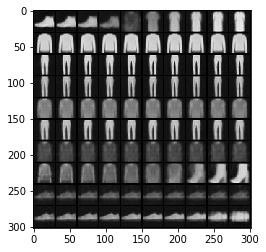

In [10]:
trial = Trial(model, callbacks=[
    plot_progress(SAMPLES, num_images=100, nrow=10)
], verbose=1).with_generators(test_generator=testgen)
trial.to('cuda')
_ = trial.for_test_steps(1).evaluate(data_key=torchbearer.TEST_DATA)

## Final Comments
So there we have it, a quick tour of beta-VAEs on FashionMNIST.  Notice that FashionMNIST doesn't disentangle quite as nicely as CelebA, probably because of the large variation in the images. Although, with a bit of hyperparameter tuning this can probably be improved.